# Gamma Regression (California Housing Data)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/Gamma_Regression_CaliforniaHousing.ipynb)

# Imports

In [2]:
from xgboostlss.model import *
from xgboostlss.distributions.Gamma import *
from xgboostlss.distributions.LambertWGamma import *

from sklearn import datasets
from sklearn.model_selection import train_test_split
import multiprocessing
import seaborn as sns

# Data

In [3]:
n_cpu = multiprocessing.cpu_count()

housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

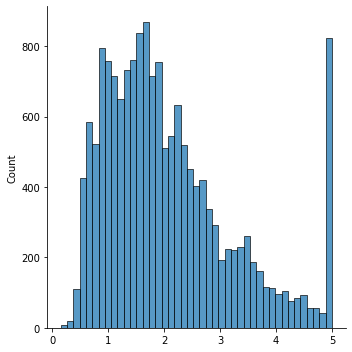

In [4]:
sns.displot(y_train)

# Distribution Selection

In [5]:
# Specifies Gamma distribution with exp response function and option to stabilize Gradient/Hessian. Type ?Gamma for an overview.
xgblss = XGBoostLSS(
     TailLambertWGamma(stabilization="L2",     # Options are "None", "MAD", "L2".
          response_fn="exp",      # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
          loss_fn="nll"           # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
         )
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [6]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-11-26 06:48:03,928] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


   0%|          | 00:00/05:00

[I 2023-11-26 06:52:36,516] Trial 0 finished with value: 4241.6933596 and parameters: {'eta': 0.0004765032692801988, 'max_depth': 10, 'gamma': 0.32390027924290615, 'subsample': 0.4687170870433711, 'colsample_bytree': 0.5501183906811657, 'min_child_weight': 7.72916011231836e-08, 'booster': 'gbtree'}. Best is trial 0 with value: 4241.6933596.
[I 2023-11-26 06:57:47,755] Trial 1 finished with value: 7038.9685548 and parameters: {'eta': 0.015362493669936065, 'max_depth': 3, 'gamma': 0.0001551101379407888, 'subsample': 0.6588779536382067, 'colsample_bytree': 0.817924878277035, 'min_child_weight': 0.00018677455343255397, 'booster': 'gbtree'}. Best is trial 0 with value: 4241.6933596.

Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  2
  Best trial:
    Value: 4241.6933596
    Params: 
    eta: 0.0004765032692801988
    max_depth: 10
    gamma: 0.32390027924290615
    subsample: 0.4687170870433711
    colsample_bytree: 0.5501183906811657
    min_child_weight: 

# Model Training

In [7]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [8]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [9]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.760481,1.640663,2.152873,2.185267,1.723177,0.689740,2.668554,2.265327,1.374613,3.571632,...,2.269982,2.156312,1.435175,2.691890,2.985337,2.005457,1.642383,1.717164,2.901754,1.365790
1,1.793098,1.498976,1.958096,1.645665,1.904501,1.151722,2.098940,1.218689,2.428411,3.360309,...,1.850324,1.184750,1.990375,0.544136,0.714728,2.691124,1.482418,1.879947,1.124123,0.635293
2,0.839810,2.706971,3.603774,2.553088,1.853427,3.279834,2.758267,1.214659,3.746180,1.500916,...,1.261845,0.395252,1.161396,1.987080,5.225013,2.089243,1.296448,2.636876,2.829599,2.455628
3,2.088769,3.327139,3.102762,2.756464,2.923243,1.311901,0.815334,0.874706,2.760581,2.449710,...,0.942616,1.157994,3.077299,4.459748,1.480096,1.848930,3.539145,1.751831,3.307787,1.059894
4,2.822268,2.828410,5.009146,1.875809,1.962789,1.040902,2.238626,2.801578,2.485047,17.864244,...,1.908084,1.433038,1.798815,3.758025,4.893122,6.232454,3.393425,3.414547,1.710207,4.037218


In [10]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,0.652875,4.648087
1,0.584484,3.922211
2,0.588323,4.550708
3,0.633592,4.316581
4,0.824954,6.335644


In [11]:
pred_params.head()

,concentration,rate,tailweight
0,3.688961,1.833692,0.016860
1,3.540566,1.951046,0.012316
2,3.619555,1.864006,0.012314
3,3.692813,1.830138,0.008956
4,4.108185,1.749351,0.044259


In [13]:
pred_params["mean"] = pred_params["concentration"] / pred_params["rate"]
pred_params["var"] = pred_params["mean"] / pred_params["rate"]

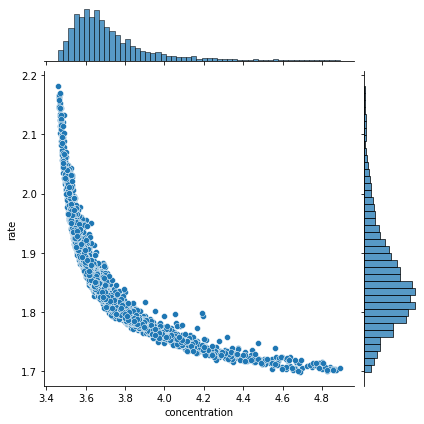

In [12]:
sns.jointplot(data=pred_params, x="concentration", y="rate")

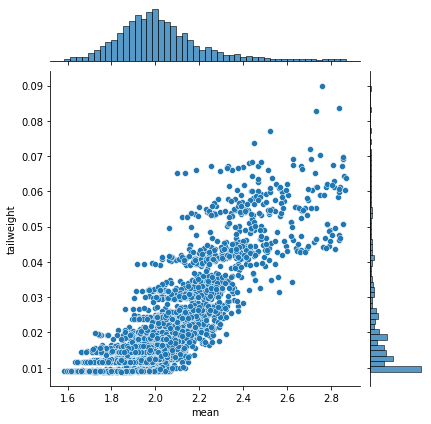

In [15]:
sns.jointplot(data=pred_params, x="mean", y="tailweight")

# SHAP Interpretability

[07:19:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


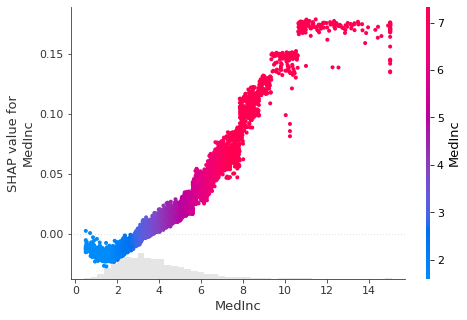

In [16]:
# Partial Dependence Plot
pdp_df = pd.DataFrame(X_train, columns=feature_names)
xgblss.plot(pdp_df,
            parameter="concentration",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

In [ ]:
xgblss.plot(pdp_df,
            parameter="tailweight",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

In [17]:
# Feature Importance
xgblss.plot(pdp_df,
            parameter="tailweight",
            plot_type="Feature_Importance")

[07:21:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


KeyboardInterrupt: 